# GARCH(p,q) model based on Apple to predict volatility

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yf
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

When handling the TS model, one of the most important step is remove the outlier

In [7]:
df = yf.download('AAPL', '2009-01-01', '2023-12-31')['Adj Close']
df.shape
df_ret = np.log(df).diff().dropna()*100
df_ret

[*********************100%%**********************]  1 of 1 completed


Date
2009-01-05    4.133759
2009-01-06   -1.663138
2009-01-07   -2.184517
2009-01-08    1.839875
2009-01-09   -2.313474
                ...   
2023-12-22   -0.556288
2023-12-26   -0.284496
2023-12-27    0.051777
2023-12-28    0.222381
2023-12-29   -0.543887
Name: Adj Close, Length: 3773, dtype: float64

In [19]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    axes[1][0].set_ylim(-0.3, 0.3)
    axes[1][1].set_ylim(-0.3, 0.3)
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

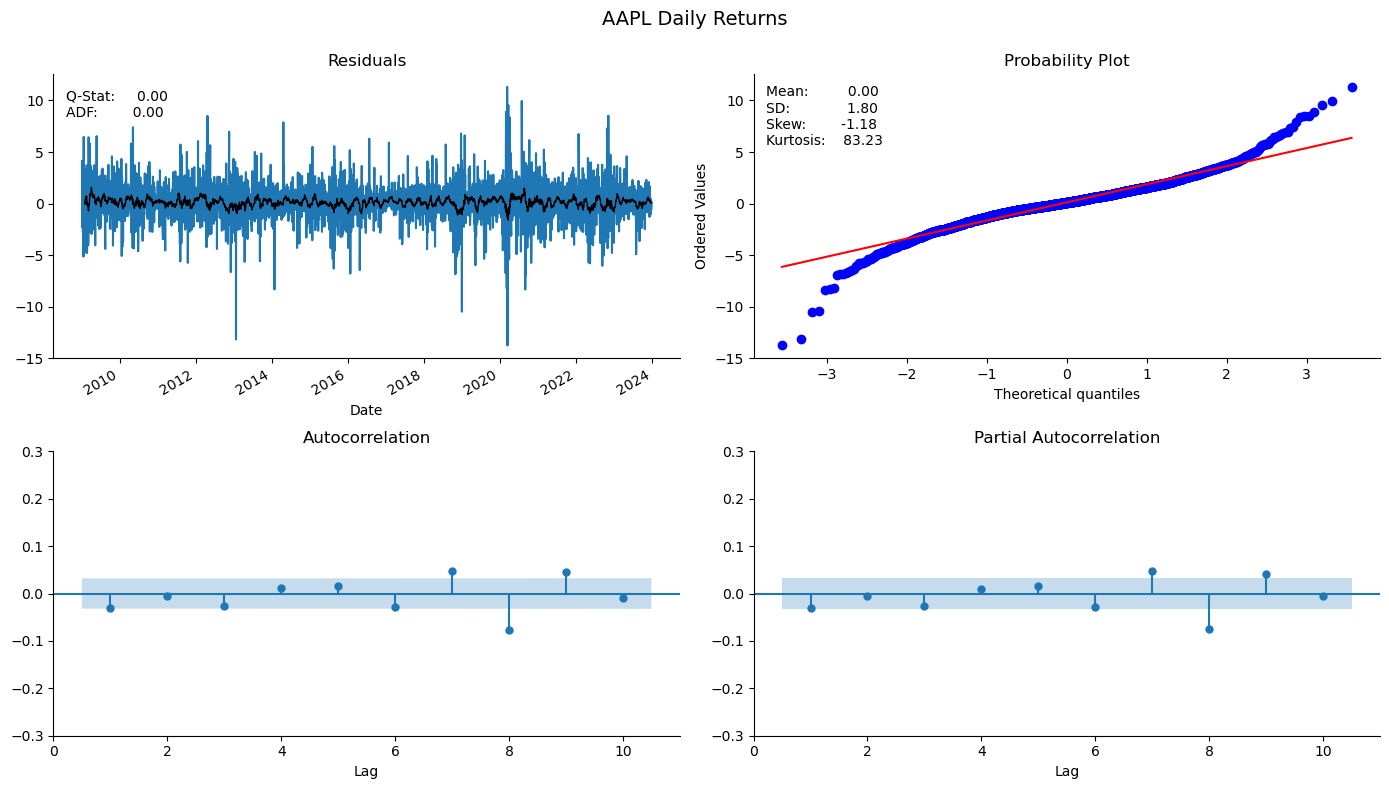

In [21]:
plot_correlogram(df_ret, lags=10, title='AAPL Daily Returns')

There is no delay/pattern in ACF and PACF for apple daily return, which means the TS model cannot be applied on return

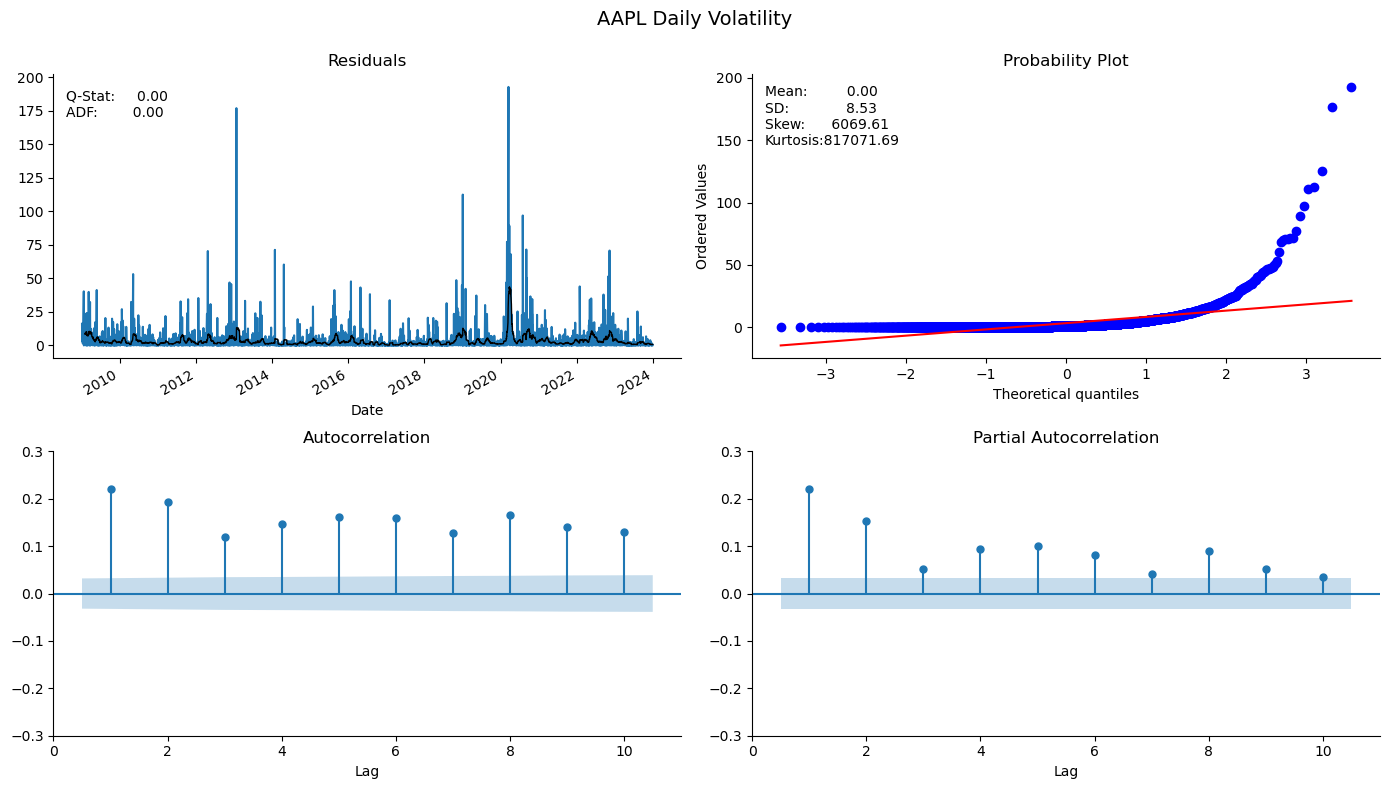

In [22]:
plot_correlogram(df_ret.sub(df_ret.mean()).pow(2), lags=10, title='AAPL Daily Volatility')

Therefore, we can use TS model on the volatility. In order to predict the volatility, the GARCH Model is the most popular one. Here is the GARCH(p,q) Model:

$$
h_t = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j h_{t-j}
$$

where, $\omega$, $\alpha$, and $\beta$ are parameters

In [31]:
trainsize = 5 * 252
#Delete the outliers
data = df_ret.clip(lower = df_ret.quantile(.05), upper = df_ret.quantile(.95))

size = len(df_ret)
size
results = {}
for p in range(1, 5):
    for q in range(1, 5):
        result = []
        for s, t in enumerate(range(trainsize, size-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off') #keep the result clean
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

In [32]:
results

{(1, 1): 2.4119213313015955,
 (1, 2): 2.413869146751266,
 (1, 3): 2.414466265833706,
 (1, 4): 2.4136622366033293,
 (2, 1): 2.412258992100153,
 (2, 2): 2.4152095869411943,
 (2, 3): 2.414934516258789,
 (2, 4): 2.415329776007314,
 (3, 1): 2.4119785245563237,
 (3, 2): 2.4145577630964534,
 (3, 3): 2.415661944246312,
 (3, 4): 2.4155794239374964,
 (4, 1): 2.4125224386923683,
 (4, 2): 2.415048685069832,
 (4, 3): 2.415893864831943,
 (4, 4): 2.413782415261849}

Be aware of cons of GARCH model that it treats the positive and negative volatility are the same(have the same effect). In empirical, however, they have different reflection on the market.

While selecting the TS model, we have a rule of thumb: the less parameter we have, the better more is. (If the RMSE is close enough). There are two major test we can rely on: AIC and BIC in the summary of model.

We can tell that the RMSE is quite similar for p and q value, so we choose the simplest model.

In [38]:
am = ConstantMean(df_ret.clip(lower=df_ret.quantile(.05),
                                      upper=df_ret.quantile(.95)))
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()
mod = am.fit(update_freq=5)
mod.summary()

Iteration:      5,   Func. Count:     38,   Neg. LLF: 6590.70949344934
Iteration:     10,   Func. Count:     62,   Neg. LLF: 6590.4652900383235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6590.465290035185
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6590.47
Distribution:                  Normal   AIC:                           13188.9
Method:            Maximum Likelihood   BIC:                           13213.9
                                        No. Observations:                 3773
Date:                Tue, Feb 20 2024   Df Residuals:                     3772
Time:                        17:16:19   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1451  2.179e-02      6.659  2.755e-11 [  0.102,  0.188]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0440  1.680e-02      2.619  8.809e-03 [1.108e-02,7.695e-02]
alpha[1]       0.0628  1.217e-02      5.165  2.409e-07 [3.899e-02,8.667e-02]
beta[1]        0.9153  1.884e-02     48.577      0.000     [  0.878,  0.952]
============================================================================

Covariance estimator: robust
"""

As a result, this model is statistically significant. We can determine the parameter of the GARCH(1,1) from the table.

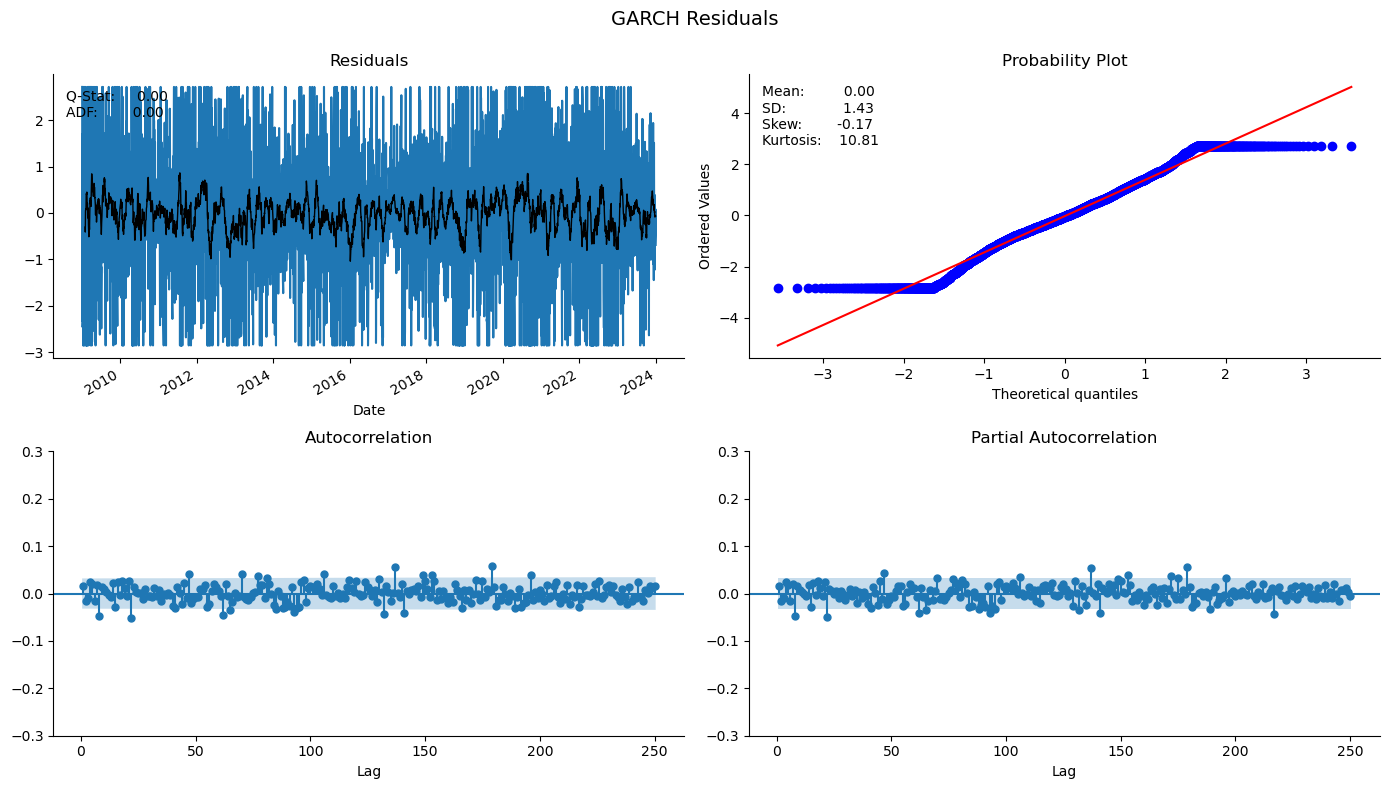

In [36]:
plot_correlogram(mod.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')